<a href="https://colab.research.google.com/github/CeesGniewyk/Recommender-Systems/blob/master/Assignment_3_2_Image_Caption_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 3.2. Image Caption Generation**

Cees Gniewyk - 0859034 <br>
Celine Senden - 0865165 <br>
Timothy de Vries - 0740585

# Preparation

## Mounting Google and Installing Packages

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
import os
import sys
import codecs
import operator
import numpy as np
import string
import re
import glob
from numpy import array
from tqdm import tqdm
from time import time
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
import _pickle as cPickle
from pickle import dump, load
import operator
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Input, CuDNNLSTM, Bidirectional
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Embedding, TimeDistributed, Dense, RepeatVector, Add, Lambda,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
import keras.optimizers as opt
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


## Preprocessing Data, if not yet done, only run once, takes a long time

### Loading Dataset

In [0]:
flicker_path = 'Colab Notebooks/Assignment 3/Data/Task 2 Dataset'

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = flicker_path+'/'"Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
def load_descriptions(doc):
  
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
    
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with pi

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, flicker_path+'/'+"descriptions.txt")

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = flicker_path+'/'"Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

NameError: ignored

In [0]:
# load validation dataset (1K)
dev_fn = flicker_path+'/'"Flickr_8k.devImages.txt"
dev = load_set(dev_fn)
print('Validation Dataset: %d' % len(dev))

Validation Dataset: 1000


In [0]:
# load test dataset (1K)
test_fn = flicker_path+'/'"Flickr_8k.testImages.txt"
test = load_set(test_fn)
print('Test Dataset: %d' % len(test))

Test Dataset: 1000


In [0]:
# Below path contains all the images
images = flicker_path+'/'"Flicker8k_Dataset/"
# Create a list of all image names in the directory
img = glob.glob(images+'*.jpg')

In [0]:
# Below file contains the names of images to be used in train data
train_images_file = flicker_path+'/'"Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in validation data
dev_images_file = flicker_path+'/'"Flickr_8k.devImages.txt"
# Read the validation image names in a set# Read the test image names in a set
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
dev_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in dev_images: # Check if the image belongs to test set
        dev_img.append(i) # Add it to the list of test images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = flicker_path+'/'"Flickr_8k.testImages.txt"
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(flicker_path+'/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

NameError: ignored

In [0]:
# descriptions
dev_descriptions = load_clean_descriptions(flicker_path+'/descriptions.txt', dev)
print('Descriptions: validation=%d' % len(dev_descriptions))

Descriptions: validation=1000


In [0]:
# descriptions
test_descriptions = load_clean_descriptions(flicker_path+'/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

### Transfer Learning from Inception model that is trained on Imagenet

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 3s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 2527.1292567253113


In [0]:
# Save the bottleneck train features to disk
with open(flicker_path+"/encoded_train_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_train, encoded_pickle)

In [0]:
start = time()
encoding_dev = {}
for img in tqdm(dev_img):
    encoding_dev[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 1000/1000 [06:58<00:00,  2.44it/s]

Time taken in seconds = 418.93302273750305


In [0]:
# Save the bottleneck train features to disk
with open(flicker_path+"/encoded_dev_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_dev, encoded_pickle)


In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 1000/1000 [07:00<00:00,  2.29it/s]

Time taken in seconds = 420.87346625328064


In [0]:
# Save the bottleneck test features to disk
with open(flicker_path+"/encoded_test_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_test, encoded_pickle)

In [0]:
train_features = load(open(flicker_path+"/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [0]:
dev_features = load(open(flicker_path+"/encoded_dev_images.pkl", "rb"))
print('Photos: dev=%d' % len(dev_features))

Photos: dev=1000


In [0]:
test_features = load(open(flicker_path+"/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

NameError: ignored

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(flicker_path, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1652, 300)

In [0]:
max_length # max sequence length of caption

34

### caption

In [0]:
len(train_descriptions)

6000

In [0]:
train_descriptions['990890291_afc72be141']

['startseq man does wheelie on his bicycle on the sidewalk endseq',
 'startseq man is doing wheelie on mountain bike endseq',
 'startseq man on bicycle is on only the back wheel endseq',
 'startseq asian man in orange hat is popping wheelie on his bike endseq',
 'startseq man on bicycle riding on only one wheel endseq']

In [0]:
len(train_features)

6000

In [0]:
train_features['990890291_afc72be141.jpg']

array([0.00971352, 0.23514009, 0.35254925, ..., 0.05749099, 0.9089289 ,
       0.3645004 ], dtype=float32)

## After Preprocessed once, run these to import

In [0]:
flicker_path = 'Colab Notebooks/Assignment 3/Data/Task 2 Dataset'

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = flicker_path+'/'"Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = flicker_path+'/'"Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# load validation dataset (1K)
dev_fn = flicker_path+'/'"Flickr_8k.devImages.txt"
dev = load_set(dev_fn)
print('Validation Dataset: %d' % len(dev))

Validation Dataset: 1000


In [0]:
# load test dataset (1K)
test_fn = flicker_path+'/'"Flickr_8k.testImages.txt"
test = load_set(test_fn)
print('Test Dataset: %d' % len(test))

Test Dataset: 1000


In [0]:
# Below path contains all the images
images = flicker_path+'/'"Flicker8k_Dataset/"
# Create a list of all image names in the directory
img = glob.glob(images+'*.jpg')

In [0]:
# Below file contains the names of images to be used in train data
train_images_file = flicker_path+'/'"Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in validation data
dev_images_file = flicker_path+'/'"Flickr_8k.devImages.txt"
# Read the validation image names in a set# Read the test image names in a set
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
dev_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in dev_images: # Check if the image belongs to test set
        dev_img.append(i) # Add it to the list of test images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = flicker_path+'/'"Flickr_8k.testImages.txt"
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(flicker_path+'/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
# descriptions
dev_descriptions = load_clean_descriptions(flicker_path+'/descriptions.txt', dev)
print('Descriptions: validation=%d' % len(dev_descriptions))

Descriptions: validation=1000


In [0]:
# descriptions
test_descriptions = load_clean_descriptions(flicker_path+'/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [0]:
train_features = load(open(flicker_path+"/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [0]:
dev_features = load(open(flicker_path+"/encoded_dev_images.pkl", "rb"))
print('Photos: dev=%d' % len(dev_features))

Photos: dev=1000


In [0]:
test_features = load(open(flicker_path+"/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(flicker_path, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1652, 300)

In [0]:
max_length # max sequence length of caption

34

# Task 2.1: Encoder Decoder Model

Build an image caption generator model, as described in Vinyals, Oriol, et al. "Show and tell: A neural image caption generator." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015. The model shall consist of:

- Image encoder (image feature extractor)
- Caption generator (RNN-based)



## Model

### Image Encoder

In [0]:
rnn_dim = 300

In [0]:
# image input
image_in = Input(shape=(2048,), name='image_inputs')

In [0]:
# image encoder
fe1 = Dropout(0.5, name='dropout_img_feats')(image_in)
image_dense = Dense(rnn_dim, activation='relu', name = 'dense_img_feats')
fe2 = image_dense(fe1) # reduce the dimension with FC projection

### Caption Generator

In [0]:
# caption input
cap_in = Input(shape=(None,),name='caption_inputs')

# caption embedding representation (word-based embedding)
embed_cap = Embedding(vocab_size, rnn_dim, weights = [embedding_matrix], trainable = False) # with dimension (, None, embedding_dim)

# state input for each decoder time step
s0 = Input(shape=(rnn_dim,), name='s0') # with a dimension of (, rnn_dim)
s = [s0]

# LSTM/GRU decoder as caption generator
# decoder = ### YOUR CODE HERE
se1 = embed_cap(cap_in)
drop_cap = Dropout(0.5)
se2 = drop_cap(se1)
lstm_layer = LSTM(300)
se3 = lstm_layer(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(300, activation='relu')
dense_decoder = decoder2(decoder1)

# Prediction layer with softmax activation
pred_layer = Dense(vocab_size, activation='softmax')
outputs = pred_layer(dense_decoder)

In [0]:
# probs = []

# # process the training per time step (following the max length of captions)
# for t in range(decoder_length):
    
#     ### YOUR CODE HERE
    
#     ### ... HOW DO YOU REPRESENT JOINT-REPRESENTATION OF IMAGE-CAPTION AS DECODER INPUT? 
    
#     ### ... HOW DO YOU INITIALIZE THE RNN-BASED DECODER STATE IN TIME STEP=0? 
    
#     if t == 0:
        
#     ### ... WHAT IS THE INPUT OF THE DECODER? 
    
    
#     s, _ = ### YOUR CODE HERE
    
#     # softmax probability output
#     prob = pred_layer(s)
    
#     probs.append(prob)
#     s = [s]

IndentationError: ignored

### The model shall be constructed based on the following inputs

In [0]:
# Construct the model
model = Model(inputs=[image_in, cap_in], outputs=outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
image_inputs (InputLayer)       (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    495600      caption_inputs[0][0]             
__________________________________________________________________________________________________
dropout_img_feats (Dropout)     (None, 2048)         0           image_inputs[0][0]               
__________________________________________________________________________________________________
dropout_2 

In [0]:
adam = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

### Training

In [0]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 92s 46ms/step - loss: 4.0010 - acc: 0.2538
Epoch 1/1
2000/2000 [==============================] - 91s 45ms/step - loss: 3.3225 - acc: 0.3058
Epoch 1/1
2000/2000 [==============================] - 92s 46ms/step - loss: 3.1122 - acc: 0.3243
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.9782 - acc: 0.3357
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.8745 - acc: 0.3464
Epoch 1/1
2000/2000 [==============================] - 91s 45ms/step - loss: 2.7974 - acc: 0.3530
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.7311 - acc: 0.3596
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.6781 - acc: 0.3643
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.6324 - acc: 0.3689
Epoch 1/1
2000/2000 [==============================] - 91s 46ms/step -

# Task 2.2: Decoder Model

Based on the completed encoder-decoder, build a decoder model for generating captions using two approaches:
- Greedy search
- Beam search

In [0]:
model.load_weights('./model_9.h5')


In [0]:
test_img_in = []
test_cap_true = []
img_keys = []
for key, desc_list in test_descriptions.items():
  
  img_vect = test_features[key+'.jpg'].reshape((1,2048))
    
  for desc in desc_list:
       
    test_img_in.append(img_vect)
    test_cap_true.append(desc)
    img_keys.append(key)


In [0]:
def create_decoder_model():
  
  # image features from encoder outputs
  enc_out = Input(shape=(300,), name='')
  
  in_decoder = Input(shape=(None, ))
  
  in_dec_embedded =  embed_cap(in_decoder)
  in_dec_embedded = drop_cap(in_dec_embedded)
  
  enc_cap = lstm_layer(in_dec_embedded)
  
  
  
  x_cap = Reshape((1, 300))(enc_cap)
  x_img = Reshape((1, 300))(enc_out)
  
  context_concat = add([x_cap, x_img])

  
  s = decoder2(context_concat)
  
  softmax_prob = pred_layer(s)
  
  decoder_model = Model([in_decoder] + [enc_out]  , [softmax_prob] )
  
  return decoder_model
  

In [0]:
encoder_model = Model(inputs=image_in, outputs=fe2)

In [0]:
decoder_model = create_decoder_model()

In [0]:
test_img_in = []
test_cap_true = []
img_keys = []
for key, desc_list in test_descriptions.items():
  
  img_vect = test_features[key+'.jpg'].reshape((1,2048))
    
  for desc in desc_list:
       
    test_img_in.append(img_vect)
    test_cap_true.append(desc)
    img_keys.append(key)


In [0]:
encoder_model = Model(inputs=image_in, outputs=fe2)

In [0]:
decoder_model = create_decoder_model()

### Greedy search

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
def greedy_generator(in_images):
  
  in_text = 'startseq'
  img_feats = encoder_model.predict(in_images)

  decoded_text = ''
  
  for i in range(max_length):
    
    sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = decoder_model.predict([sequence, img_feats], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
        break
        
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final
    

### Beam search

In [0]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption 


### Examples

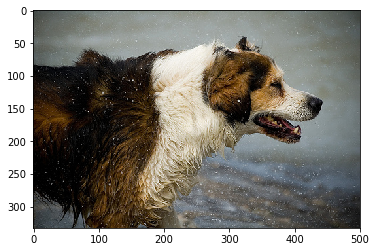

In [0]:
x=plt.imread(images+img_keys[44]+'.jpg')
plt.imshow(x)
plt.show()

In [0]:
test_img_in = []
test_cap_true = []
img_keys = []
for key, desc_list in test_descriptions.items():
  
  img_vect = test_features[key+'.jpg'].reshape((1,2048))
    
  for desc in desc_list:
       
    test_img_in.append(img_vect)
    test_cap_true.append(desc)
    img_keys.append(key)


In [0]:
greedy_generator(test_img_in[44])

'dog is running through the water'

In [0]:
beam_search_predictions(test_img_in[44])

NameError: ignored